<a href="https://colab.research.google.com/github/WilliamShengYangHuang/RC18_Machine_Learning/blob/main/LeNet_image_classification_skill_module_class_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LeNet

In this notebook, we will be implementing a version of LeNet-5, a neural network model that uses convolutional neural network (CNN) layers and was designed for classifying handwritten characters. CNNs are ubiquitous in modern computer vision. Almost every neural network model for computer vision contains many CNN layers, also referred to as convolutional layers, thus they're an important concept to understand. We will explain how they work when we implement the model.

The image below shows the architecture of LeNet-5. It consists of two convolutional layers, each followed by a subsampling layer, and then three fully connected linear layers.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)


### Data Processing

As always, we'll import the modules we need...

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

...set the random seed for reproducability...

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

...and calculate the mean and standard deviation across our training set so we can normalize our data.

In [ ]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then, we'll define our train and test transforms...

In [ ]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

...load our train and test data...

In [ ]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

...and create a validation set from 10% of our training data.

Remember that the validation set should always be taken from the training data, and never the test data.

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

The validation set is using the same transforms as the training set, as it was created from it. As we want our validation set to remain static, to better resemble our test set, we replace these with the test transforms - remembering to `deepcopy` the validation set. 
In the case of deep copy, a copy of the object is copied into another object. It means that any changes made to a copy of the object do not reflect in the original object. 

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

We'll print out the number of examples in the training/validation/test sets to ensure everything has been loaded correctly.

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


The final part of the data processing stage is to create our dataloaders/iterators.

Again, we use a batch size of 64 and only shuffle the training data each epoch.

In [ ]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Defining the Model

Now we've gone through all the concepts, we can implement our model.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)

Our actual implementation is going to slightly differ from the actual LeNet architecture, as it was built to handle 32x32 images, whereas the MNIST dataset consists of 28x28 images. We're also not going to use the Gaussian connections at the end, instead we'll just use a standard linear layer.

The first layer in our model is a convolutional layer with 6 filters (PyTorch calls them `out_channels`) and a kernel size of 5. This turns our `[1, 28, 28]` image into `[6, 24, 24]`. We then downsample our image with a max pooling layer that has a filter size of 2 to get a `[6, 12, 12]` image. This is then passed through an activation function, ReLU in this case, which is applied elementwise and does not change the of the image. 

Afterwards, we pass the image to the second convolutional layer with 16 filters that are 5x5x6, a height and width of 5 and a depth of 6 as our previous convolutional layer had 6 filters. This gives us an image size of `[16, 8, 8]` which we then max pool to half the height and width to `[16, 4, 4]` and then pass through another ReLU function.

We then flatten our `[16, 4, 4]` image to `[256]` and pass this through three linear layers. Each of the linear layers are followed by another ReLU, except for the last.

We return the results from the final linear layer as well as from the flattened result of the second convolutional layer, which we can plot in lower dimensions later.

Note that you should always apply your activation function **after** the pooling layer. You will get the exact same results if you apply the activation function before, however this means you will be applying your activation function to a larger number of inputs, increasing the computation required. Using the activation function after the image has been reduced in size means it will be applied to fewer inputs and thus use less computation.

In [ ]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 4 * 4, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):

        # x = [batch size, 1, 28, 28]
        x = self.conv1(x)
        # x = [batch size, 6, 24, 24]
        x = F.max_pool2d(x, kernel_size=2)
        # x = [batch size, 6, 12, 12]
        x = F.relu(x)

        x = self.conv2(x)
        # x = [batch size, 16, 8, 8]
        x = F.max_pool2d(x, kernel_size=2)
        # x = [batch size, 16, 4, 4]
        x = F.relu(x)

        x = x.view(x.shape[0], -1)
        # x = [batch size, 16*4*4 = 256]

        x = self.fc_1(x)
        # x = [batch size, 120]
        x = F.relu(x)
        x = self.fc_2(x)

        # x = batch size, 84]
        x = F.relu(x)
        x = self.fc_3(x)
        # x = [batch size, output dim]

        return x

The rest of the notebook is similar to the previous ones.

We'll create an instance of the model...

In [ ]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

### Training the Model

We define our optimizer...

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

...place the model and criterion on the device...

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

...define a function to calculate accuracy...

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...define a function that performs a training epoch...

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...define a function that performs an evaluation epoch...

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...define a function that tells us how long an epoch takes...

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

...and finally we can begin training!


In [ ]:
EPOCHS = 5

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 30s
	Train Loss: 0.418 | Train Acc: 86.46%
	 Val. Loss: 0.117 |  Val. Acc: 96.42%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 28s
	Train Loss: 0.136 | Train Acc: 95.70%
	 Val. Loss: 0.080 |  Val. Acc: 97.62%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 28s
	Train Loss: 0.101 | Train Acc: 96.80%
	 Val. Loss: 0.073 |  Val. Acc: 97.61%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.084 | Train Acc: 97.32%
	 Val. Loss: 0.060 |  Val. Acc: 98.24%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 0.069 | Train Acc: 97.79%
	 Val. Loss: 0.060 |  Val. Acc: 98.22%


We load the parameters which performed the best on the validation set and then evaluate our performance on the test set.

Just like the validation accuracy, we get 99% test accuracy!

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.046 | Test Acc: 98.54%


### Examining the Model

we'll examine our model by: plotting a confusion matrix, seeing which incorrect examples our model was most confident about

First, we'll get the model's predictions across the test set...

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)

...and then get the predicted labels from the model's predictions.

In [ ]:
pred_labels = torch.argmax(probs, 1)

Next, we'll plot the confusion matrix.

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

The only real problem the model seemed to have is predicting 2s as 7s.

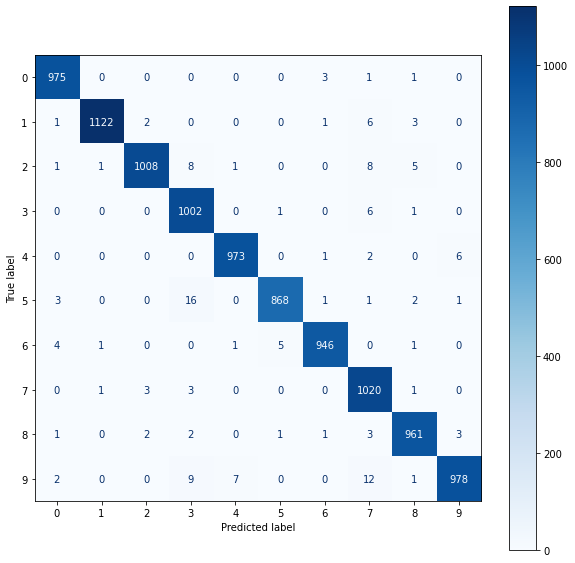

In [ ]:
plot_confusion_matrix(labels, pred_labels)

Next, we'll find out which of our examples are correct...

In [ ]:
corrects = torch.eq(labels, pred_labels)

...then get all of the incorrect examples and sort them by descending confidence in their prediction.

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

We can then use this to plot the examples the model got wrong and was most confident about.

In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

The mistakes look pretty reasonable. All the digits shown here are a bit off.

The model is always trained to be incredibly confident with its predictions, so it's not unreasonable for it to be incredibly confident when it's wrong.

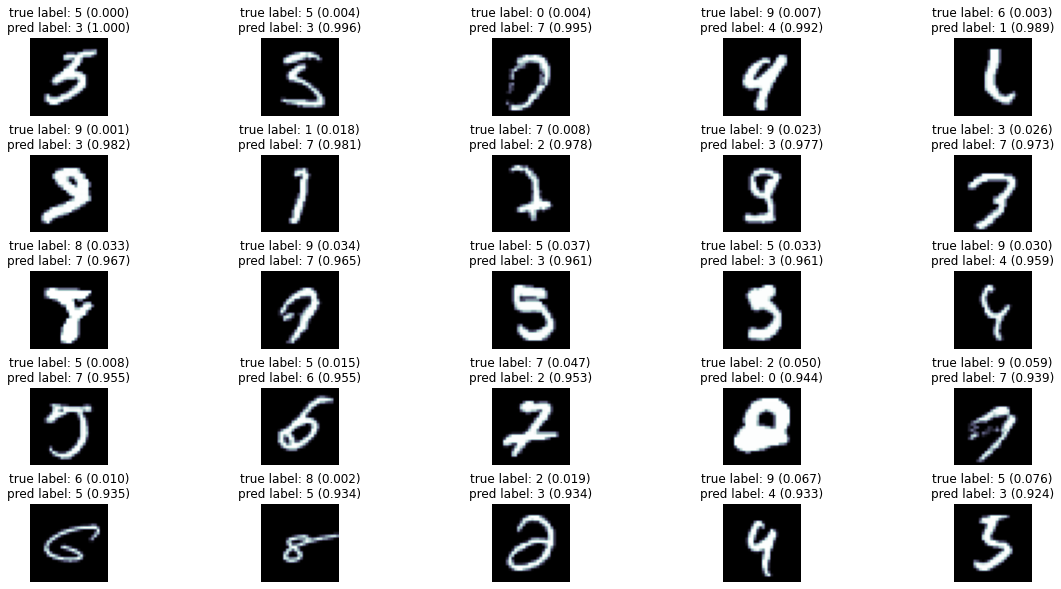

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)